In [169]:
# !pip install catboost

In [170]:

# ===================================================================
# Telnet Attack 
# Network Security Project 
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [171]:
df = pd.read_csv(r'..\Dataset\final_datasetv3.csv')


In [172]:
print(f" Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")

 Dataset loaded: 5725 rows × 12 columns

Column names:
['frame.time_epoch', 'frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.len', 'tcp.stream', 'tcp.window_size', 'label']


In [173]:
df.head()

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,label
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0


In [174]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   frame.time_epoch     5725 non-null   object
 1   frame.time_delta     5725 non-null   object
 2   frame.time_relative  5725 non-null   object
 3   frame.len            5725 non-null   object
 4   ip.proto             5725 non-null   object
 5   tcp.srcport          5725 non-null   object
 6   tcp.dstport          5725 non-null   object
 7   tcp.flags            5725 non-null   object
 8   tcp.len              5725 non-null   object
 9   tcp.stream           5725 non-null   object
 10  tcp.window_size      5725 non-null   object
 11  label                5725 non-null   object
dtypes: object(12)
memory usage: 536.8+ KB
None


In [175]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [176]:
missing = df.isnull().sum()
print(f"\n Missing Values per Feature:")
for col, miss in missing.items():
    if miss > 0:
        print(f"   {col}: {miss} ({miss/len(df)*100:.2f}%)")
if missing.sum() == 0:
    print("  No missing values found!")


 Missing Values per Feature:
  No missing values found!


In [177]:
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")


 Duplicate Rows: 0


In [178]:
print(df.describe())


            frame.time_epoch frame.time_delta frame.time_relative frame.len  \
count                   5725             5725                5725      5725   
unique                  5725             5699                5725        46   
top     1765999986.825697327      0.000020219         0.001675444        66   
freq                       1                2                   1      2785   

       ip.proto tcp.srcport tcp.dstport tcp.flags tcp.len tcp.stream  \
count      5725        5725        5725      5725    5725       5725   
unique        2         345         345         8      44        237   
top           6          23          23    0x0018       0          3   
freq       5724        1555        1777      2232    3492        236   

       tcp.window_size label  
count             5725  5725  
unique              22     3  
top               5888     1  
freq              2155  3125  


In [179]:
df_clean = df.dropna()

In [180]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [181]:
print(f" Final dataset: {len(df_clean)} rows")

 Final dataset: 5725 rows


In [182]:
X = df_clean.drop('label', axis=1)
y = df_clean['label']

In [183]:
X.select_dtypes(include='object').head()


,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888


In [184]:
print(X['tcp.flags'].unique()[:20])

['0x0002' '0x0012' '0x0010' '0x0018' '0x0011' '0x0004' 'tcp.flags'
 '0x0014']


In [185]:
flags = {
    'FIN': 0x01,
    'SYN': 0x02,
    'RST': 0x04,
    'PSH': 0x08,
    'ACK': 0x10,
    'URG': 0x20
}

def safe_flag(x, value):
    try:
        return int(x, 16) & value > 0
    except:
        return 0  

for flag, value in flags.items():
    X[f'tcp_{flag}'] = X['tcp.flags'].apply(lambda x: safe_flag(x, value)).astype(int)


In [186]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,0x0018,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0x0011,0,104,63744,1,0,0,0,1,0


In [187]:
X = X.drop(columns=['tcp.flags'])

In [188]:
flag_cols = ['tcp_FIN','tcp_SYN','tcp_RST','tcp_PSH','tcp_ACK','tcp_URG']
X[flag_cols] = X[flag_cols].astype(int)

In [189]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0,104,63744,1,0,0,0,1,0


In [190]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5720    1
5721    1
5722    1
5723    1
5724    1
Name: label, Length: 5725, dtype: object

In [191]:
X = X.drop(columns=['frame.time_epoch','frame.time_delta','frame.time_relative','tcp.srcport', 'tcp.dstport'])

In [192]:
# Convert all features to numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y[X.index]

y = y.astype(int)
y = y[y.isin([0, 1])]
X = X.loc[y.index]

print(f"After preprocessing: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Label distribution:\n{y.value_counts()}")

After preprocessing: 5724 samples, 11 features
Label distribution:
label
1    3125
0    2599
Name: count, dtype: int64


In [193]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Temporary split for feature selection:")
print(f"  Training: {X_train_temp.shape[0]} samples")
print(f"  Testing: {X_test_temp.shape[0]} samples")

rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    n_features_to_select=8,
    step=1
)
rfe_selector.fit(X_train_temp, y_train_temp)
rfe_ranking = rfe_selector.ranking_
rfe_importance = 1 / rfe_ranking 

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rfe_importance
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance (from training data only):")
print(feature_importance)
top_features = feature_importance.head(8)['feature'].tolist()
print(f"\nSelected Top 8 Features: {top_features}")

X_train_selected = X_train_temp[top_features]
X_test_selected = X_test_temp[top_features]
y_train_selected = y_train_temp
y_test_selected = y_test_temp

Temporary split for feature selection:
  Training: 4579 samples
  Testing: 1145 samples

Feature Importance (from training data only):
            feature  importance
0         frame.len    1.000000
2           tcp.len    1.000000
3        tcp.stream    1.000000
7           tcp_RST    1.000000
4   tcp.window_size    1.000000
5           tcp_FIN    1.000000
6           tcp_SYN    1.000000
8           tcp_PSH    1.000000
9           tcp_ACK    0.500000
10          tcp_URG    0.333333
1          ip.proto    0.250000

Selected Top 8 Features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_RST', 'tcp.window_size', 'tcp_FIN', 'tcp_SYN', 'tcp_PSH']


In [194]:
print(f"Using selected features: {top_features}")
print(f"Final dataset shape: Train={X_train_selected.shape}, Test={X_test_selected.shape}")

Using selected features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_RST', 'tcp.window_size', 'tcp_FIN', 'tcp_SYN', 'tcp_PSH']
Final dataset shape: Train=(4579, 8), Test=(1145, 8)


In [195]:
# split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_selected, y_train_selected, test_size=0.15, random_state=42, stratify=y_train_selected
)

# Keep test set separate (never used for training or validation)
X_test = X_test_selected.copy()
y_test = y_test_selected.copy()

print(f"Final splits:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"\nTraining label distribution:\n{y_train.value_counts()}")

Final splits:
  Training: 3892 samples
  Validation: 687 samples
  Testing: 1145 samples

Training label distribution:
label
1    2125
0    1767
Name: count, dtype: int64


In [196]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)


In [197]:
print(y_train.value_counts())
print(pd.Series(y_train).value_counts())


label
1    2113
0    2113
Name: count, dtype: int64
label
1    2113
0    2113
Name: count, dtype: int64


In [198]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 4226 samples
Testing set: 1145 samples


In [199]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)  

In [200]:
# Random Forest with cross-validation
print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
rf_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = rf_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = rf_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

RANDOM FOREST CLASSIFIER
Cross-validation F1 scores: [0.8891455  0.89381564 0.88584475 0.8929385  0.87310827]
Mean CV F1: 0.8870 (+/- 0.0150)

Validation Set Performance:
  F1: 0.9031
  Balanced Accuracy: 0.8895

Test Set Performance:
  Accuracy: 0.8952
  Precision: 0.8964
  Recall: 0.9136
  F1-Score: 0.9049
  Balanced Accuracy: 0.8933

Confusion Matrix:
[[454  66]
 [ 54 571]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       520
           1       0.90      0.91      0.90       625

    accuracy                           0.90      1145
   macro avg       0.90      0.89      0.89      1145
weighted avg       0.90      0.90      0.90      1145



In [201]:
# SVM with cross-validation
print("="*60)
print("SVM (RBF) CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    class_weight='balanced',
    random_state=42,
    probability=True
)

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
svm_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = svm_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

SVM (RBF) CLASSIFIER
Cross-validation F1 scores: [0.82916213 0.83533261 0.83278689 0.81578947 0.80400891]
Mean CV F1: 0.8234 (+/- 0.0236)

Validation Set Performance:
  F1: 0.8475
  Balanced Accuracy: 0.8142

Test Set Performance:
  Accuracy: 0.8332
  Precision: 0.8145
  Recall: 0.8992
  F1-Score: 0.8548
  Balanced Accuracy: 0.8265

Confusion Matrix:
[[392 128]
 [ 63 562]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       520
           1       0.81      0.90      0.85       625

    accuracy                           0.83      1145
   macro avg       0.84      0.83      0.83      1145
weighted avg       0.84      0.83      0.83      1145



In [202]:
# Decision Tree 
print("="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_model = DecisionTreeClassifier(
    max_depth=10, 
    class_weight='balanced',
    min_samples_split=20,  
    min_samples_leaf=10,   
    random_state=42
)

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
dt_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = dt_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = dt_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

DECISION TREE CLASSIFIER
Cross-validation F1 scores: [0.89201878 0.89220183 0.90127758 0.88452656 0.88317757]
Mean CV F1: 0.8906 (+/- 0.0130)

Validation Set Performance:
  F1: 0.8992
  Balanced Accuracy: 0.8879

Test Set Performance:
  Accuracy: 0.8943
  Precision: 0.9000
  Recall: 0.9072
  F1-Score: 0.9036
  Balanced Accuracy: 0.8930

Confusion Matrix:
[[457  63]
 [ 58 567]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       520
           1       0.90      0.91      0.90       625

    accuracy                           0.89      1145
   macro avg       0.89      0.89      0.89      1145
weighted avg       0.89      0.89      0.89      1145



In [203]:
# XGBoost 
print("="*60)
print("XGBOOST CLASSIFIER")
print("="*60)

xgb_model = XGBClassifier(
    n_estimators=500,  
    max_depth=6, 
    learning_rate=0.1, 
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)


# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Final evaluation on test set
y_pred = xgb_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

XGBOOST CLASSIFIER
Cross-validation F1 scores: [0.8760139  0.87203791 0.87771429 0.86936416 0.86935867]
Mean CV F1: 0.8729 (+/- 0.0069)

Test Set Performance:
  Accuracy: 0.8812
  Precision: 0.8912
  Recall: 0.8912
  F1-Score: 0.8912
  Balanced Accuracy: 0.8802

Confusion Matrix:
[[452  68]
 [ 68 557]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       520
           1       0.89      0.89      0.89       625

    accuracy                           0.88      1145
   macro avg       0.88      0.88      0.88      1145
weighted avg       0.88      0.88      0.88      1145



In [204]:
# LightGBM with early stopping and regularization
print("="*60)
print("LIGHTGBM CLASSIFIER")
print("="*60)

lgbm_model = LGBMClassifier(
    n_estimators=500,  
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1, 
    n_jobs=-1
)

LIGHTGBM CLASSIFIER


In [205]:
lgbm_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_val_scaled, y_val)],  # Use validation set, not test set
    eval_metric='binary_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
)

print(f"Best iteration: {lgbm_model.best_iteration_ if hasattr(lgbm_model, 'best_iteration_') else 'N/A'}")

# Cross-validation
cv_scores = cross_val_score(lgbm_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Best iteration: 54
Cross-validation F1 scores: [0.85981308 0.86114352 0.87104072 0.86337543 0.86690224]
Mean CV F1: 0.8645 (+/- 0.0082)


In [206]:
# Evaluate on validation set first
y_pred_val_lgbm = lgbm_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val_lgbm):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val_lgbm):.4f}")

# Final evaluation on test set
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
prec_lgbm = precision_score(y_test, y_pred_lgbm)
rec_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
bal_acc_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)


Validation Set Performance:
  F1: 0.9103
  Balanced Accuracy: 0.8991


In [207]:
print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc_lgbm:.4f}")
print(f"  Precision: {prec_lgbm:.4f}")
print(f"  Recall: {rec_lgbm:.4f}")
print(f"  F1-Score: {f1_lgbm:.4f}")
print(f"  Balanced Accuracy: {bal_acc_lgbm:.4f}")
print(f"\nConfusion Matrix:\n{cm_lgbm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lgbm)}")


Test Set Performance:
  Accuracy: 0.9074
  Precision: 0.9165
  Recall: 0.9136
  F1-Score: 0.9151
  Balanced Accuracy: 0.9068

Confusion Matrix:
[[468  52]
 [ 54 571]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       520
           1       0.92      0.91      0.92       625

    accuracy                           0.91      1145
   macro avg       0.91      0.91      0.91      1145
weighted avg       0.91      0.91      0.91      1145



In [208]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500, 
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
    max_depth=10, class_weight='balanced',random_state=42,
    )
    ,
    'XGBoost': XGBClassifier(
    n_estimators=500, 
    max_depth=8,     
    learning_rate=0.05,
    subsample=0.8,   
    colsample_bytree=0.8, 
    min_child_weight=3,   
    scale_pos_weight=1.2,  
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
),
    'CatBoost': CatBoostClassifier(
        iterations=500,
        depth=8,
        learning_rate=0.05,
        l2_leaf_reg=3,
        bootstrap_type='Bernoulli',
        subsample=0.8,
        random_seed=42,
        verbose=False,
        task_type='CPU',
        thread_count=-1
    )

}

In [209]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    try:
        # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, 
                                    scoring='f1', n_jobs=-1)
        print(f"Cross-validation F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Train with early stopping for gradient boosting models
        if name in ['XGBoost']:
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_val_scaled, y_val)],
            )
        elif name == 'CatBoost':
            model.fit(
                X_train_scaled, y_train,
                eval_set=(X_val_scaled, y_val),
                verbose=False,
            )
        else:
            model.fit(X_train_scaled, y_train)
        
        # Evaluate on validation set
        y_pred_val = model.predict(X_val_scaled)
        val_f1 = f1_score(y_val, y_pred_val)
        print(f"Validation F1: {val_f1:.4f}")
        
        # Final evaluation on test set
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'val_f1': val_f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'balanced_accuracy': bal_acc,
            'confusion_matrix': cm,
            'predictions': y_pred
        }
        
        print(f"Test F1: {f1:.4f}")
        
    except Exception as e:
        print(f" Error training {name}: {str(e)}")
        continue


Training Random Forest...
Cross-validation F1: 0.8807 (+/- 0.0157)
Validation F1: 0.8982
Test F1: 0.8973

Training Decision Tree...
Cross-validation F1: 0.8918 (+/- 0.0029)
Validation F1: 0.9048
Test F1: 0.9030

Training XGBoost...
Cross-validation F1: 0.8816 (+/- 0.0062)
[0]	validation_0-logloss:0.66853
[1]	validation_0-logloss:0.63490
[2]	validation_0-logloss:0.60412
[3]	validation_0-logloss:0.58025
[4]	validation_0-logloss:0.55397
[5]	validation_0-logloss:0.53470
[6]	validation_0-logloss:0.51224
[7]	validation_0-logloss:0.50102
[8]	validation_0-logloss:0.48532
[9]	validation_0-logloss:0.46635
[10]	validation_0-logloss:0.44907
[11]	validation_0-logloss:0.43298
[12]	validation_0-logloss:0.41791
[13]	validation_0-logloss:0.40350
[14]	validation_0-logloss:0.39273
[15]	validation_0-logloss:0.38315
[16]	validation_0-logloss:0.37136
[17]	validation_0-logloss:0.36263
[18]	validation_0-logloss:0.35232
[19]	validation_0-logloss:0.34458
[20]	validation_0-logloss:0.33495
[21]	validation_0-logl

In [210]:
if len(results) > 0:
    best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    best_f1 = results[best_model_name]['f1_score']
    best_recall = results[best_model_name]['recall']
    print(f" Best Model Automatically Selected: {best_model_name}")
    print(f"   Test F1-Score: {best_f1:.4f}")
    print(f"   Test Recall: {best_recall:.4f} (Critical for IDS!)")
    print(f"   Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
else:
    best_model_name = 'LightGBM'  # Fallback
    print(f"  No results available. Using default: {best_model_name}")


 Best Model Automatically Selected: CatBoost
   Test F1-Score: 0.9148
   Test Recall: 0.9104 (Critical for IDS!)
   Test Accuracy: 0.9074


In [211]:
comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [r['accuracy'] for r in results.values()],
       'Precision': [r['precision'] for r in results.values()],
       'Recall': [r['recall'] for r in results.values()],
       'F1-Score': [r['f1_score'] for r in results.values()],
        'Balanced Accuracy': [r['balanced_accuracy'] for r in results.values()]
    })

In [212]:
print(comparison_df.to_string(index=False))

        Model  Accuracy  Precision  Recall  F1-Score  Balanced Accuracy
Random Forest  0.886463   0.886115  0.9088  0.897314           0.884208
Decision Tree  0.894323   0.905145  0.9008  0.902967           0.893669
      XGBoost  0.879476   0.883465  0.8976  0.890476           0.877646
     CatBoost  0.907424   0.919225  0.9104  0.914791           0.907123


In [213]:
for name, result in results.items():
    print(f"\n{name}:")
    cm = result['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                Predicted Normal  Predicted Attack")
    print(f"Actual Normal   {cm[0][0]:^16}  {cm[0][1]:^16}")
    print(f"Actual Attack   {cm[1][0]:^16}  {cm[1][1]:^16}")
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}") 
    print(f"True Positives (TP):  {tp}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, result['predictions'], 
                                target_names=['Normal', 'Attack']))


Random Forest:

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         447                73       
Actual Attack          57               568       

True Negatives (TN):  447
False Positives (FP): 73
False Negatives (FN): 57
True Positives (TP):  568

Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.86      0.87       520
      Attack       0.89      0.91      0.90       625

    accuracy                           0.89      1145
   macro avg       0.89      0.88      0.89      1145
weighted avg       0.89      0.89      0.89      1145


Decision Tree:

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         461                59       
Actual Attack          62               563       

True Negatives (TN):  461
False Positives (FP): 59
False Negatives (FN): 62
True Positives (TP):  563

Classification Report:
              precision    recall  f1-score

Visualization saved as 'model_comparison.png'


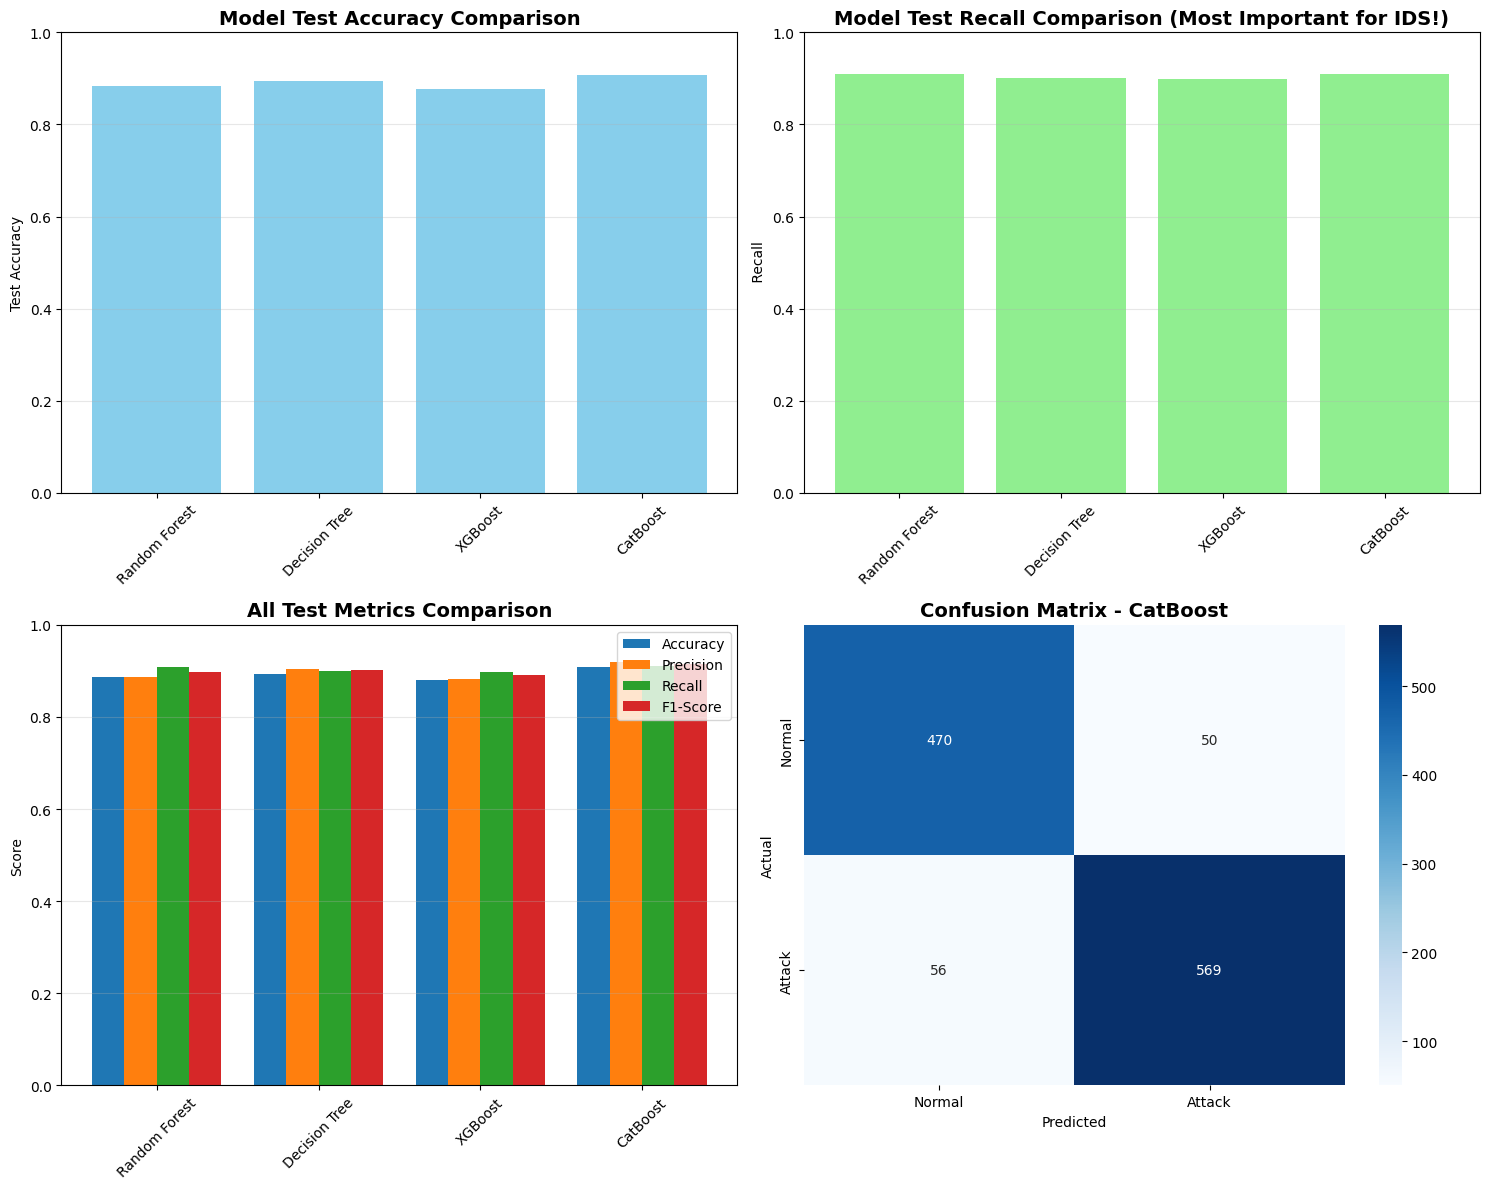

In [214]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Balanced Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_ylim([0, 1.0])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Test Recall comparison (most important for IDS!)
axes[0, 1].bar(comparison_df['Model'], comparison_df['Recall'], color='lightgreen')
axes[0, 1].set_title('Model Test Recall Comparison (Most Important for IDS!)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel(' Recall')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# All test metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[1, 0].bar(x + i*width, comparison_df[metric], width, 
                   label=metric.replace('Test_', ''))

axes[1, 0].set_title('All Test Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x + width * 1.5)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.0])
axes[1, 0].grid(axis='y', alpha=0.3)

# Confusion matrix for best model
cm_best = results[best_model_name]['confusion_matrix']
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'], ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'model_comparison.png'")

In [215]:
import joblib

# Save the best model (LightGBM based on results)
best_model = results[best_model_name]['model']
print("best model" , best_model)
joblib.dump(best_model, r'..\saved models\cb_telnet_ids_model.pkl')
joblib.dump(scaler, r'..\saved models\scalercb.pkl')
joblib.dump(top_features, r'..\saved models\featurescb.pkl')  # Use top_features from feature selection

print("Model, scaler, and features saved successfully!")
print(f"Saved features: {top_features}")

best model <catboost.core.CatBoostClassifier object at 0x000002239CA65520>
Model, scaler, and features saved successfully!
Saved features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_RST', 'tcp.window_size', 'tcp_FIN', 'tcp_SYN', 'tcp_PSH']


In [ ]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load(r'..\saved models\cb_telnet_ids_model.pkl')
scaler = joblib.load(r'..\saved models\scalercb.pkl')
features = joblib.load(r'..\saved models\featurescb.pkl')

def predict_attack(sample_dict):
    # إنشاء DataFrame من العينة
    df = pd.DataFrame([sample_dict])
    
    # إضافة أي features ناقصة بقيمة 0 (افتراضياً)
    for feature in features:
        if feature not in df.columns:
            df[feature] = 0
    
    # ترتيب الأعمدة بنفس ترتيب التدريب
    df = df[features]
    
    # التحقق من الأنواع الرقمية
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # التحقق من NaN
    if df.isnull().any().any():
        nan_cols = df.columns[df.isnull().any()].tolist()
        raise ValueError(f"NaN values found in features: {nan_cols}")
    
    # التطبيع
    df_scaled = scaler.transform(df)
    
    # التنبؤ
    pred = model.predict(df_scaled)[0]
    prob = model.predict_proba(df_scaled)[0]
    
    return {
        "prediction": "ATTACK" if pred == 1 else "NORMAL",
        "attack_probability": float(prob[1]),
        "normal_probability": float(prob[0])
    }

# عينات محدثة لتشمل جميع الـ 8 features
sample_attack = {
    'frame.len': 138,
    'tcp.len': 72,
    'tcp.stream': 104,
    'tcp_RST': 1,
    'tcp.window_size': 5888,
    'tcp_FIN': 0,
    'tcp_SYN': 0,
    'tcp_PSH': 1
}

sample_normal = {
    'frame.len': 66,
    'tcp.len': 0,
    'tcp.stream': 0,
    'tcp_RST': 0,
    'tcp.window_size': 64240,
    'tcp_FIN': 0,
    'tcp_SYN': 1,
    'tcp_PSH': 0
}

print("="*50)
print("TESTING ATTACK DETECTION MODEL")
print("="*50)
print(f"Using features: {features}")

print("\n1. Sample 1 (Expected: ATTACK):")
try:
    result1 = predict_attack(sample_attack)
    print(f"   Prediction: {result1['prediction']}")
    print(f"   Attack Probability: {result1['attack_probability']:.2%}")
    print(f"   Normal Probability: {result1['normal_probability']:.2%}")
except Exception as e:
    print(f"   Error: {e}")

print("\n2. Sample 2 (Expected: NORMAL):")
try:
    result2 = predict_attack(sample_normal)
    print(f"   Prediction: {result2['prediction']}")
    print(f"   Attack Probability: {result2['attack_probability']:.2%}")
    print(f"   Normal Probability: {result2['normal_probability']:.2%}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.to_string(index=False))

TESTING ATTACK DETECTION MODEL
Using features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_RST', 'tcp.window_size', 'tcp_FIN', 'tcp_SYN', 'tcp_PSH']

1. Sample 1 (Expected: ATTACK):
   Prediction: ATTACK
   Attack Probability: 89.89%
   Normal Probability: 10.11%

2. Sample 2 (Expected: NORMAL):
   Prediction: NORMAL
   Attack Probability: 40.15%
   Normal Probability: 59.85%

FEATURE IMPORTANCE
        feature  importance
     tcp.stream   34.282680
tcp.window_size   29.651145
        tcp_PSH   12.980032
      frame.len   11.259352
        tcp.len    9.989029
        tcp_FIN    1.551222
        tcp_SYN    0.220839
        tcp_RST    0.065702
